In [36]:
# Importa bibliotecas
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
from scipy import stats
from itertools import combinations,chain, product, permutations
import warnings
import os
import sys

In [37]:
# Data máxima de operação comercial máxima a considerar para utilizar na determinação dos coeficientes. As usinas que entrarem depois dessa data
# serão utilizadas para calcular o erro do previsor
data_OC_max = "2022-10-1"


# Plotar gráficos. Pode demorar consideravelmente o tempo de execução. 
PLOT_GRAPH = True

In [38]:
warnings.filterwarnings("default")
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [39]:
# Realiza df.groupby(groups).agg({cols[n] : agg_funcs}) com suporte a desvio padrão com datas
# E eliminação de outliers utilizando z-score
def gb_agg(df : pd.DataFrame,groups: list, cols : list,agg_funcs : list,z_score_max = None,expand_last_level=False):
    agrupamentos = {}
    dic = {}
    index = []
    for group in groups:
        agrupamentos[group] = list(df[group].unique())
    permutas = list(product(*agrupamentos.values()))
    for col in cols:
        for func in agg_funcs:
            dic[col,func] = {}
            for var1 in permutas:
                mask = pd.Series(index = df.index,dtype=bool)
                mask_outlier = pd.Series(index = df.index,dtype=bool)
                for idx,var2 in enumerate(var1):
                    mask &= df[groups[idx]] == var2
                if z_score_max:
                    if df[col].dtype != np.dtype('<M8[ns]'):
                        std = df.loc[mask,col].std()
                        m = df.loc[mask,col].mean()
                        val_max = (z_score_max*std)+m
                        val_min = -(z_score_max*std)+m
                        mask_outlier = ~(((df[col]) > val_max) | ((df[col]) < val_min))
                    else:
                        pass
                res = eval(f"df.loc[mask & mask_outlier,col].{func}()")
                dic[col,func][var1] = res
    df_gb = pd.DataFrame(dic)
    df_gb.index.names = groups

    return df_gb

# Tratamento da base de dados

In [40]:
# Importa dataframe com informações dos dois bancos de dados
bd_combined = pd.read_parquet("./Intermediarios/bd_combined.gzip")

# Renomeia coluna índice
bd_combined.index.name = "índice"

# Transforma IDs em strings
bd_combined.IdeUsinaOutorga = bd_combined.IdeUsinaOutorga.astype(str)


# Remove linhas cujas colunas Dat_OC_obrigacao e DatLiberOpComerRealizado não sejam nulas, já que ambas
# informações serão utilizadas para possibilitar o cálculo do atraso.
mask_OC_notna = bd_combined.Dat_OC_obrigacao.notna() & bd_combined.DatLiberOpComerRealizado.notna()
bd_combined = bd_combined[mask_OC_notna].copy()

In [41]:
# Lista com informações básicas da usina
lista_colunas_basic_info = ["IdeUsinaOutorga","SigTipoGeracao","origem","DscComercializacaoEnergia"]

# Lista com datas que serão utilizadas
lista_colunas_datas_usadas = ["DatInicioObraRealizado","DatConcretagemRealizado","DatMontagemRealizado","DatLiberacaoSFGTeste","DatLiberOpComerRealizado",'Dat_OC_obrigacao']


# Dicionários com nomes das fases e o correspondente marco que marca seu início
dict_fase_marco = {
    "IO_OC" : "DatInicioObraRealizado",
    "CC_OC" : "DatConcretagemRealizado",
    "ME_OC" : "DatMontagemRealizado",
    "OT_OC" : "DatLiberacaoSFGTeste"
}
dict_marco_nome = {v: k for k, v in dict_fase_marco.items()}


# Dataframe onde serão feitos os cálculos
calc = bd_combined.loc[:,lista_colunas_basic_info + lista_colunas_datas_usadas].copy()

In [42]:
# Renomeia IDs das UHEs para que cada UG tenha uma ID parcialmente diferente, para que se tenha um maior conjunto de dados
#  de UHEs, onde cada UG é tratada como uma usina
# Exemplo: as n UGs da UHE 12 terão IDs 12_0, 12_1, ... 12_n 
mask_UHE_duplicate = (calc.SigTipoGeracao == "UHE") & (calc.IdeUsinaOutorga.duplicated(keep=False)) 
calc.loc[mask_UHE_duplicate,"IdeUsinaOutorga"] = calc.loc[mask_UHE_duplicate,"IdeUsinaOutorga"] +"_"+ calc.loc[mask_UHE_duplicate].groupby("IdeUsinaOutorga").cumcount().astype(str)

## Calcula duração de cada fase por UG

In [43]:
lista_colunas_tempo_fase = []
for fase,marco in dict_fase_marco.items():
    calc[fase] = calc["DatLiberOpComerRealizado"]-  calc[marco]
    lista_colunas_tempo_fase.append(fase)
# Coluna Atraso refere-se ao atraso da OC
calc["Atraso"]  =  calc["DatLiberOpComerRealizado"]-  calc["Dat_OC_obrigacao"]
calc.head(5)

IdeUsinaOutorga SigTipoGeracao   origem DscComercializacaoEnergia  \
índice                                                                     
0                 12_0            UHE  bdworgs                       ACR   
1                 12_1            UHE  bdworgs                       ACR   
2                   19            UTE  bdworgs               Fora do ACR   
3                 42_0            UHE  bdworgs                       ACR   
4                 42_1            UHE  bdworgs                       ACR   

       DatInicioObraRealizado DatConcretagemRealizado DatMontagemRealizado  \
índice                                                                       
0                  2004-10-15              2006-08-23           2008-01-14   
1                  2004-10-15              2006-08-23           2008-02-04   
2                  2006-09-15                     NaT                  NaT   
3                  2001-05-31                     NaT                  NaT   
4                  2001-05-31                     NaT                  NaT   

       DatLiberacaoSFGTeste DatLiberOpComerRealizado Dat_OC_obrigacao  \
índice                                                                  
0                2008-12-17               2008-12-25       2007-03-01   
1                2009-02-28               2009-03-12       2008-09-01   
2                2008-04-12               2008-04-18       2002-01-01   
3                2005-07-20               2005-07-30       2003-11-30   
4                2005-08-20               2005-08-31       2005-08-31   

           IO_OC    CC_OC    ME_OC   OT_OC    Atraso  
índice                                                
0      1532 days 855 days 346 days  8 days  665 days  
1      1609 days 932 days 402 days 12 days  192 days  
2       581 days      NaT      NaT  6 days 2299 days  
3      1521 days      NaT      NaT 10 days  608 days  
4      1553 days      NaT      NaT 11 days    0 days

## Remove incosistências e gera tabela com motivos para eliminação

In [44]:
# Variável booleana que indica se está na primeira iteração do loop
is_first = True 

# Combinações 2 a 2 de todos os tempos de fase 
combinacoes = list(combinations([x for x in dict_fase_marco.keys() ],2))

# Dataframe com motivo de eliminação
motivo_eliminacao = calc[["SigTipoGeracao","origem","IdeUsinaOutorga"]].copy(deep=True)

# Adciona coluna para descrição do motivo da eliminação
motivo_eliminacao["motivo_eliminacao"] = ""

# Itera sobre a lista com os tempos de fase "decombinacoes" de tal forma que p_fase é uma fase que tem que ocorrer antes de
# s_fase e, portanto, p_fase > s_fase
for p_fase, s_fase in combinacoes:
    # Máscara parcial com linhas que estão na ordem correta
    mask_ordem_correta_parcial =  ((calc[p_fase] >= calc[s_fase]) | 
                 calc[p_fase].isna() |
                 calc[s_fase].isna())
    
    # Adiciona no dataframe a descrição do motivo da eliminação
    motivo_eliminacao.loc[~mask_ordem_correta_parcial,"motivo_eliminacao"] += f"{s_fase[:-3]}>{p_fase[:-3]},"
    
    # Máscara final com linhas que estão na ordem correta, que faz E lógico com a máscara parcial
    mask_ordem_correta = mask_ordem_correta_parcial if is_first else (mask_ordem_correta & mask_ordem_correta_parcial)
    
    is_first = False 
motivo_eliminacao =motivo_eliminacao[~mask_ordem_correta]
calc = calc[mask_ordem_correta].copy(deep=True)

## Mantém apenas a primeira UG de cada usina a entrar em OC

In [45]:
# Máscara com índices corresponde às primeiras UGs a entrarem em operação comercial
idx_primeira_ug =  calc.groupby(["IdeUsinaOutorga"]).DatLiberOpComerRealizado.idxmin()

# Considera-se apenas a primeira UG a entrar em OC, removendo linhas que não
# correspondam a estas, pois a correlação dos atrasos fica muito baixa quando todas as UGs foram utilizadas. 
calc = calc.loc[idx_primeira_ug,:].copy()

In [46]:
# Separa algumas usinas para serem usadas para avaliar a previsão de operação comercial    
    
# Máscara das UGs que entraram em Operação Comercial até abril de 2022
mask_dados_base = calc.DatLiberOpComerRealizado < data_OC_max

In [47]:
lista_comercializacao = ["Ambos","ACR", "Fora do ACR"]
lista_colunas_outliers = []
# Adiciona Colunas para outliers
for comercializacao in lista_comercializacao:
    for fase in dict_fase_marco.keys():
        coluna = f"Outlier_{fase}_{comercializacao}"
        lista_colunas_outliers.append(coluna)
        calc[coluna] = False

#### Calcula  tempo medio por fase e geracao já desconsiderando outliers

In [48]:
z_score_max = 1.65 # Escore-z que representa percentil de aproximadamente 90%. Será usado para a identificação de outliers
calc["Outlier"] = False # Coluna que indica se há alguma duração de fase que é um outlier na linha
tipos_geracao = calc.SigTipoGeracao.unique() # lista com os tipos de geracao

# dicionário onde serão guardados as medias e os desvios padrão dos tempos de fase por tipo de comercialização, fase, tipo de geracao
dict_tempo_fase_mean_std = {} 


lista_colunas_tempo_fase_media = []
lista_colunas_tempo_fase_std = []
lista_comercializacao = ["Ambos","ACR", "Fora do ACR"]
#lista_colunas_marcos
for comercializacao in lista_comercializacao:
    dict_tempo_fase_mean_std[comercializacao]= {}
    for fase in dict_fase_marco.keys():
        dict_tempo_fase_mean_std[comercializacao][fase] = {}
        for i,SigTipoGeracao in enumerate(tipos_geracao):
            dict_tempo_fase_mean_std[comercializacao][fase][SigTipoGeracao]  = {}
            
            # Máscara com o tipo de geracao e comercialização
            mask_geracao = (calc.SigTipoGeracao==SigTipoGeracao)
            if comercializacao != "Ambos":
                mask_geracao &= (calc.DscComercializacaoEnergia== comercializacao)
            
            # Calcula  média e desvio padrão dos tempos de fase para os tipos de geração 
            m = calc.loc[mask_geracao & mask_dados_base,fase].mean()
            std = calc.loc[mask_geracao & mask_dados_base,fase].std()
            
            # Tempo máximo de duração das fases para identificar outliers
            tempo_max = +(z_score_max*std)+m
            tempo_mim = -(z_score_max*std)+m
            
            # Máscara com outliers
            outliers = (((calc[fase]) > tempo_max)| ((calc[fase]) < tempo_mim)) & mask_geracao #& mask_dados_base
            calc.loc[outliers,f"Outlier_{fase}_{comercializacao}"] = True
            
            # Média e desvios padrão sem outliers
            media = calc.loc[mask_geracao & (~outliers) & mask_dados_base,fase].mean()
            std = calc.loc[mask_geracao & (~outliers) & mask_dados_base,fase].std()
            count = calc.loc[mask_geracao & (~outliers) & mask_dados_base,fase].count()
            
            
            # Adiciona ao dataframe de cálculos a media e desvio padrão dos tempos de fase
            if comercializacao != "Ambos": 
                calc.loc[mask_geracao,f"{fase}_media_tipo_comercializacao"] = media 
                calc.loc[mask_geracao,f"{fase}_std_tipo_comercializacao"] = std
            else:
                calc.loc[mask_geracao,f"{fase}_media_ambos"] = media 
                calc.loc[mask_geracao,f"{fase}_std_ambos"] = std
                
            # Adiciona ao dicionário a media e desvio padrão dos tempos de fase
            dict_tempo_fase_mean_std[comercializacao][fase][SigTipoGeracao][f"media"] = media
            dict_tempo_fase_mean_std[comercializacao][fase][SigTipoGeracao][f"std"] = std
            dict_tempo_fase_mean_std[comercializacao][fase][SigTipoGeracao][f"count"] = count
            calc.loc[outliers,"Outlier"] = True


# Converte dicionário em dataframe
def tempo_fase_table():
    dic = {}
    for comercializacao, inner_dict_1 in dict_tempo_fase_mean_std.items():
        for fase, inner_dict_2 in inner_dict_1.items():
            for SigTipoGeracao,inner_dict_3 in inner_dict_2.items():
                for calculo, value in inner_dict_3.items():
                    try:
                        dic[(comercializacao,calculo)][(SigTipoGeracao,fase)] = value
                    except:
                        dic[(comercializacao,calculo)] = {}
                        dic[(comercializacao,calculo)][(SigTipoGeracao,fase)] = value
    df = pd.DataFrame(dic)
    return df


df_tempo_fase_mean_std = tempo_fase_table()
df_tempo_fase_mean_std

Ambos                                    \
                                 media                         std count   
UHE IO_OC 1787 days 15:53:08.571428576 491 days 08:38:37.136915928   210   
PCH IO_OC  803 days 07:25:05.454545456 272 days 05:00:03.968715632   220   
UTE IO_OC  566 days 00:18:33.402061856 354 days 01:55:43.771681504   388   
CGH IO_OC  841 days 18:22:58.723404256 444 days 03:18:48.540189720    47   
EOL IO_OC  509 days 20:43:43.816355808 238 days 07:27:56.046069808   697   
UFV IO_OC  385 days 15:29:49.714285716 110 days 10:10:38.171557668   175   
UHE CC_OC 1605 days 02:52:10.434782608 508 days 23:19:08.545856064   184   
PCH CC_OC  580 days 18:22:49.756097560 247 days 13:11:34.551415280   205   
UTE CC_OC                          NaT                         NaT     0   
CGH CC_OC  561 days 08:22:19.534883720 325 days 12:31:27.286062560    43   
EOL CC_OC  440 days 08:59:28.876080688 233 days 09:21:58.000292252   694   
UFV CC_OC                          NaT                         NaT     0   
UHE ME_OC 1358 days 14:11:56.230366496 591 days 23:26:29.803430624   191   
PCH ME_OC  346 days 22:03:02.741116752 161 days 14:23:31.276678152   197   
UTE ME_OC  414 days 08:40:22.429906544 323 days 23:23:24.947688772   321   
CGH ME_OC  405 days 03:30:43.902439024 253 days 18:56:21.775465680    41   
EOL ME_OC            286 days 10:40:00 243 days 19:29:04.899010132   342   
UFV ME_OC  241 days 15:33:11.061452512 104 days 11:13:00.857572654   179   
UHE OT_OC   40 days 08:21:08.722466960  28 days 15:19:03.135045459   227   
PCH OT_OC   57 days 01:52:03.735408560  58 days 17:35:30.423082119   257   
UTE OT_OC   72 days 19:04:36.923076923  78 days 18:37:27.188440938   390   
CGH OT_OC   73 days 18:19:38.181818182  59 days 02:13:12.747779813    55   
EOL OT_OC   51 days 08:53:57.372262773  26 days 21:08:27.859800519   685   
UFV OT_OC   55 days 14:05:34.883720930  35 days 18:52:51.314096730   172   

                                   ACR                                    \
                                 media                         std count   
UHE IO_OC 1779 days 01:25:07.389162560 478 days 14:36:10.755415184   203   
PCH IO_OC  815 days 08:50:31.578947368 310 days 09:29:22.297648016    76   
UTE IO_OC            547 days 14:30:24 352 days 17:38:18.655623236   225   
CGH IO_OC            720 days 00:00:00 422 days 20:13:34.496241680    13   
EOL IO_OC  520 days 18:11:44.798464488 239 days 12:59:26.806794396   521   
UFV IO_OC  375 days 05:48:23.225806452 110 days 00:45:47.869691070   124   
UHE CC_OC 1595 days 14:54:03.956043952 503 days 13:05:58.723206328   182   
PCH CC_OC            568 days 15:21:36 241 days 15:39:03.154866284    75   
UTE CC_OC                          NaT                         NaT     0   
CGH CC_OC            564 days 06:00:00 380 days 01:56:48.916946212    12   
EOL CC_OC  460 days 22:29:08.374760992 236 days 05:02:32.849253620   523   
UFV CC_OC                          NaT                         NaT     0   
UHE ME_OC 1359 days 13:13:09.304812832 579 days 19:09:12.887431912   187   
PCH ME_OC  318 days 07:33:41.917808220 146 days 10:49:39.856586480    73   
UTE ME_OC  399 days 07:07:43.366336632 319 days 04:50:18.393694612   202   
CGH ME_OC            358 days 00:00:00 220 days 20:36:08.027768752    10   
EOL ME_OC  350 days 08:51:53.513513512 273 days 13:47:09.050007396   222   
UFV ME_OC  240 days 21:54:17.142857144 103 days 13:13:49.226897571   126   
UHE OT_OC             39 days 08:46:40  28 days 01:33:25.963179274   216   
PCH OT_OC   45 days 03:45:32.530120482  38 days 17:28:00.280009783    83   
UTE OT_OC             79 days 12:00:00  94 days 16:10:21.160017220   224   
CGH OT_OC             65 days 03:00:00  67 days 01:09:17.313151893    16   
EOL OT_OC   51 days 01:54:11.837524178  27 days 14:19:07.530748230   517   
UFV OT_OC   50 days 10:20:41.379310345  27 days 16:09:34.776004601   116   

                          Fora do ACR                                     
    

In [49]:
# Listas com colunas de marcos estimados e atrasos
lista_colunas_marco_estimado = []
lista_colunas_atrasos = []
lista_colunas_atrasos_tipo_geracao = []

dict_atraso_mean_std = {}
for comercializacao in ["tipo_comercializacao","ambos"]:
    dict_atraso_mean_std[comercializacao] = {}
    for fase,marco in dict_fase_marco.items():
        # Estima o marco com base nas medias das fases
        calc[f"{marco}_estimado_{comercializacao}"] = calc.Dat_OC_obrigacao - calc[f"{fase}_media_{comercializacao}"]
        lista_colunas_marco_estimado.append(f"{marco}_estimado_{comercializacao}")
        calc[f"{marco}_atraso_{comercializacao}"] = calc[marco] - calc[f"{marco}_estimado_{comercializacao}"]
        lista_colunas_atrasos.append(f"{marco}_atraso_{comercializacao}")
        

In [50]:
# Calcula media e desvio padrão dos atrasos
media_atrasos = calc.loc[~calc.Outlier,["SigTipoGeracao","DscComercializacaoEnergia"] + lista_colunas_atrasos[0:4]].groupby(["SigTipoGeracao","DscComercializacaoEnergia"])[lista_colunas_atrasos[0:4]].mean()
media_atrasos2 = calc.loc[~calc.Outlier,["SigTipoGeracao","DscComercializacaoEnergia"] + lista_colunas_atrasos[0:4]].groupby(["SigTipoGeracao"])[lista_colunas_atrasos[0:4]].mean()
media_atrasos2["DscComercializacaoEnergia"] = "Ambos"
media_atrasos2.set_index(["DscComercializacaoEnergia"],append=True,inplace=True)
media_atrasos = pd.concat([media_atrasos,media_atrasos2],axis=0,verify_integrity=True).sort_index()

In [51]:
lista_match = ["Comercialização","Fase","Tipo de geração",]
medias = pd.DataFrame(list(product(lista_comercializacao,
        dict_fase_marco.keys(),
        tipos_geracao
        )),columns=lista_match).drop_duplicates()
medias["Media_Atraso"] = pd.NA
medias["Std_Atraso"] = pd.NA

Ambos
Não foi possível calcular: CC_OC para UTE: Inputs must not be empty.
Não foi possível calcular: CC_OC para UFV: Inputs must not be empty.


DatInicioObraRealizado_atraso DatConcretagemRealizado_atraso  \
UHE                         81.4%                          80.8%   
PCH                         98.0%                          98.5%   
UTE                         92.8%                              -   
CGH                         75.7%                          93.4%   
EOL                         93.1%                          92.1%   
UFV                         95.0%                              -   

    DatMontagemRealizado_atraso DatLiberacaoSFGTeste_atraso  
UHE                       77.8%                       99.9%  
PCH                       99.3%                      100.0%  
UTE                       95.8%                       99.9%  
CGH                       94.0%                       99.9%  
EOL                       96.3%                       99.9%  
UFV                       94.7%                       99.6%

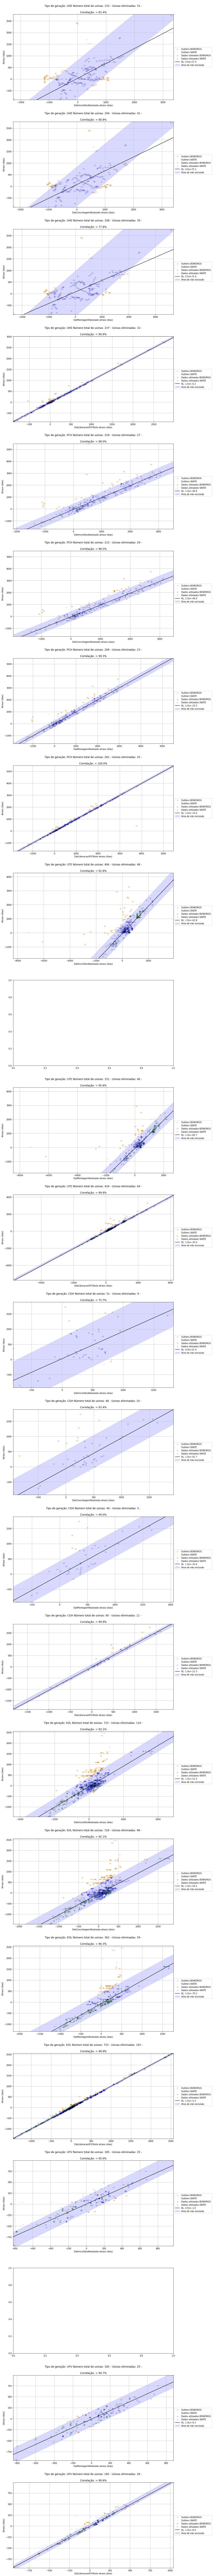

ACR
Não foi possível calcular: CC_OC para UTE: Inputs must not be empty.
Não foi possível calcular: CC_OC para UFV: Inputs must not be empty.


DatInicioObraRealizado_atraso DatConcretagemRealizado_atraso  \
UHE                         81.6%                          81.7%   
PCH                         96.3%                          97.5%   
UTE                         92.4%                              -   
CGH                         74.6%                          93.9%   
EOL                         93.9%                          93.6%   
UFV                         95.9%                              -   

    DatMontagemRealizado_atraso DatLiberacaoSFGTeste_atraso  
UHE                       79.5%                       99.9%  
PCH                       99.4%                      100.0%  
UTE                       96.0%                       99.8%  
CGH                       92.9%                       99.8%  
EOL                       95.4%                       99.9%  
UFV                       95.6%                       99.7%

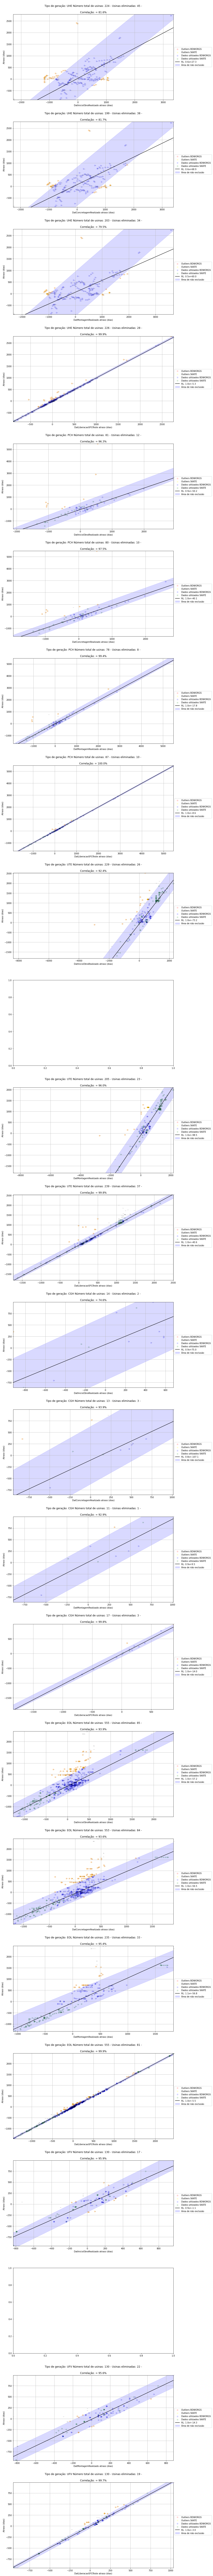

Fora do ACR
Não foi possível calcular: CC_OC para UTE: Inputs must not be empty.
Não foi possível calcular: CC_OC para UFV: Inputs must not be empty.


DatInicioObraRealizado_atraso DatConcretagemRealizado_atraso  \
UHE                         36.2%                         -99.2%   
PCH                         98.2%                          98.4%   
UTE                         92.1%                              -   
CGH                         74.2%                          94.4%   
EOL                         80.2%                          78.4%   
UFV                         90.2%                              -   

    DatMontagemRealizado_atraso DatLiberacaoSFGTeste_atraso  
UHE                      -99.7%                      100.0%  
PCH                       99.1%                       99.9%  
UTE                       93.5%                       99.9%  
CGH                       94.8%                       99.8%  
EOL                       96.0%                       99.9%  
UFV                       91.0%                       98.9%

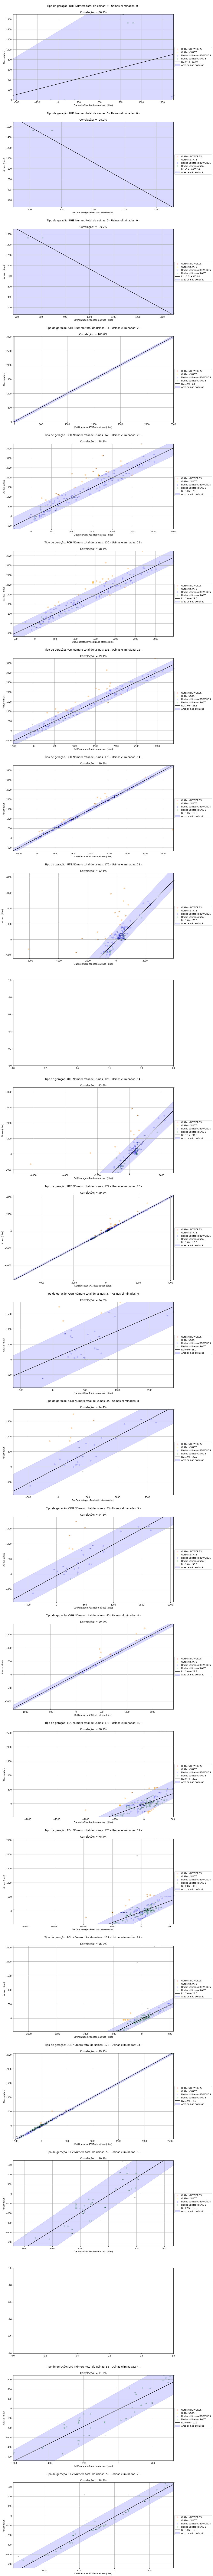

ACR             Fora do ACR                  Ambos           
                  a           b           a            b         a          b
UHE IO_OC  0.649153   27.324889    0.424335   313.865608  0.642380  27.451881
    CC_OC  0.593589   68.886914   -3.413621  4332.410272  0.594137  72.130397
    ME_OC  0.507147   59.986302   -2.539125  3474.005345  0.498385  71.616326
    OT_OC  0.994101   -5.303905    0.996041     8.447967  0.996234  -6.225824
PCH IO_OC  0.901923  -50.210217    1.025655   -76.321675  1.002077 -46.930431
    CC_OC  0.955621  -40.055649    0.996728   -29.496782  0.989691 -44.891541
    ME_OC  0.972054  -17.794007    1.012695   -26.567241  1.005998 -25.532715
    OT_OC  1.001134   -8.637529    0.996016   -10.297076  0.998404 -12.606829
UTE IO_OC  0.986417  -73.216872    0.974210   -76.455778  0.979030 -62.789373
    ME_OC  1.025592  -98.546633    1.052714   -94.623497  1.006047 -82.749966
    OT_OC  1.035798  -40.592568    1.005701   -19.462475  1.014105 -25.004212
CGH IO_OC  0.896339   74.992706    0.916974    18.163873  0.897522  21.931182
    CC_OC  0.831829 -107.133845    1.036421   -30.892639  1.004757 -61.706179
    ME_OC  0.936954    9.545161    1.028489   -56.804384  1.005571 -32.572733
    OT_OC  1.034244  -14.014150    1.017706   -21.235599  1.022798 -21.262340
EOL IO_OC  0.990435  -57.162087    0.738541   -20.150989  0.966254 -53.308973
    CC_OC  1.016142  -56.508014    0.760290   -32.234805  0.981223 -54.077134
    ME_OC  1.103403  -56.763481    0.989374   -24.586392  1.040955 -70.189860
    OT_OC  1.002024   -5.514397    1.004091    -4.464131  1.002284  -5.274933
UFV IO_OC  0.901143   -1.076536    0.911540   -15.937916  0.906216  -1.014183
    ME_OC  1.008195  -14.312951    0.889592   -10.916567  0.961478  -9.297087
    OT_OC  0.980628   -3.011731    0.997139   -11.967717  0.984728  -8.375423

In [52]:
# Calcula coeficientes da regressão linear
def calc_regression(x,y):
    res = stats.linregress(x.flatten(), y.flatten())
    a, b, r, p_value, std_err = res    
    return [a, b, r, p_value, std_err]


# Extrai arrays para a regressão linear
def extract_xy(df : pd.DataFrame, x_name : str , y_name : str, order_by : str,return_label=False):
    # Exclui linhas que tenham nulos
    idx_notna = (df[x_name].notna()) &  (df[y_name].notna())
    # Ordena dataframe
    ordered_notna = df[idx_notna].sort_values(by = order_by)
    x = ordered_notna[x_name] / pd.to_timedelta(1, unit='D')
    y = ordered_notna[y_name] / pd.to_timedelta(1, unit='D')
    # Preserva nome ddas colunas caso necessário
    if return_label:
        # Converte para float64 caso e x e y estejam em formato de data
        extract_xy.labels = ordered_notna[return_label]
    xy = np.zeros((2,x.shape[0]))
    xy[0] = x
    xy[1] = y
    return xy


# Converte dicionário em Tabela        
def coeff_table():
    dic = {}
    for comercializacao, inner_dict_1 in dict_coeffs.items():
        for SigTipoGeracao, inner_dict_2 in inner_dict_1.items():
            for atraso,inner_dict_3 in inner_dict_2.items():
                for coeff, value in inner_dict_3.items():
                    try:
                        dic[(comercializacao,coeff)][(SigTipoGeracao,atraso)] = value
                    except:
                        dic[(comercializacao,coeff)] = {}
                        dic[(comercializacao,coeff)][(SigTipoGeracao,atraso)] = value
    return pd.DataFrame(dic)

# Plota gráficos
def plot_graph(step):
    if PLOT_GRAPH:
        if step =="init":
            plot_graph.fig, plot_graph.axes = plt.subplots(num_subplots,1,figsize=(14,num_subplots*7))
        if step == "plot":
            tempo_max_mes = tempo_max.days
            tempo_min_mes = tempo_min.days
            media_mes = m.days
            ax = plot_graph.axes[count]
            x_plot = np.linspace((x_all).min()-10,(x_all).max()+10,100)
            [ax.annotate(labels[n],(x_all[n],y_all[n]),fontsize=2) for n in range(len(y_all))] #if SigTipoGeracao=="UHE" else 0
            ax.scatter(x_bwo,y_bwo,color="red",alpha=0.15,label="Outliers BDWORGS")
            ax.scatter(x_bwo,y_bwo,color="yellow",alpha=0.15,label="Outliers SKATE")

            ax.scatter(x_bw,y_bw,color="blue",alpha=0.15,label="Dados utilizados BDWORGS")
            ax.scatter(x_sk,y_sk,color="green",alpha=0.15,label="Dados utilizados SKATE")

            ax.plot(x_plot,a*x_plot+b,color="black",label= f"RL: {a:.1f}x+{b:.1f}")
            ax.set_title(f"""\nTipo de geração: {SigTipoGeracao} Número total de usinas: {x_all.shape[0]} - Usinas eliminadas: {x_bwo.shape[0] + x_sko.shape[0]} -\n\nCorrelação: = {r_str}""")
            ax.grid()
            ax.fill_between(x_plot,x_plot+tempo_min_mes-media_mes,x_plot+tempo_max_mes-media_mes,color="blue",alpha=0.15,label="Área de não exclusão")
            ax.set_xlim((x_all).min(),(x_all).max())
            ax.set_ylim((y_all).min(),(y_all).max())
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            ax.set_xlabel(f"{marco} atraso (dias)")
            ax.set_ylabel(f"Atraso (dias)")
        if step == "save":
            plt.tight_layout()
            plt.savefig(f"./Outputs/correlacao_marcos_{comercializacao}.pdf")
            plt.show()
            plt.close()


dict_comer = {"ACR": "tipo_comercializacao",
             "Fora do ACR" : "tipo_comercializacao",
             "Ambos"  : "ambos"}

z_score_max = 1.65 # Escore-z que representa percentil de aproximadamente 90%. Será usado para a identificação de outliers 
num_subplots = (len(tipos_geracao))*(4) 
dict_coeffs = {"ACR":{},"Fora do ACR":{},"Ambos":{}}
lista_colunas_dict_coeffs = []
lista_colunas_prev_OC = []
mask_bdworgs = calc.origem == "bdworgs"

for comercializacao in ["Ambos","ACR","Fora do ACR"]:
    index_pearson = []
    print(comercializacao)
    plot_graph(step="init")
    matrix_pearson = {}
    count = -1
    for i,SigTipoGeracao in enumerate(tipos_geracao):
        matrix_pearson[SigTipoGeracao] = []
        dict_coeffs[comercializacao][SigTipoGeracao] = {}
        for fase, marco in dict_fase_marco.items():      #fase in lista_colunas_atrasos:
            dict_coeffs[comercializacao][SigTipoGeracao][fase] = {}
            count+=1            
            try:
                # Máscara com apenas indices que correspondem ao tipo geração especificado
                mask_geracao = (calc.SigTipoGeracao == SigTipoGeracao )
                if comercializacao != "Ambos": mask_geracao &=  (calc.DscComercializacaoEnergia==comercializacao)               
                # Todos pares x,y para o tipo geracao tal que: x = Atraso y = Atraso do marco especificado
                x_all,y_all =  extract_xy(calc[mask_geracao & mask_dados_base], f"{marco}_atraso_{dict_comer[comercializacao]}", "Atraso", f"{marco}_atraso_{dict_comer[comercializacao]}",return_label="IdeUsinaOutorga")
                labels = extract_xy.labels.to_list()
                
                # Média e desvio padrão do tempo de duração de fase
                m = dict_tempo_fase_mean_std[comercializacao][fase][SigTipoGeracao][f"media"]
                std = dict_tempo_fase_mean_std[comercializacao][fase][SigTipoGeracao][f"std"]
                
                # Tempo máximo de duração das fases para identificar outliers
                tempo_max = (z_score_max*std)+m
                tempo_min= -(z_score_max*std)+m
                # Máscara de outliers. É utilizado o tempo de duração da fase como parêmetro, já que, por excemplo, um tempo de duração de
                # fase muito maior que a média implica um atraso em relacao ao marco médio muito menor que a média. 
                outliers = ((calc[fase]) > tempo_max)| ((calc[fase]) < tempo_min)

                # Arrays com outliers usados para plotar gráfico provenientes do skate
                x_sko,y_sko = extract_xy(calc[mask_geracao & outliers & mask_dados_base & (~mask_bdworgs)], f"{marco}_atraso_{dict_comer[comercializacao]}", "Atraso", f"{marco}_atraso_{dict_comer[comercializacao]}")
                
                # Arrays com outliers usados para plotar gráfico provenientes do skate
                x_bwo,y_bwo = extract_xy(calc[mask_geracao & outliers & mask_dados_base & (mask_bdworgs)], f"{marco}_atraso_{dict_comer[comercializacao]}", "Atraso", f"{marco}_atraso_{dict_comer[comercializacao]}")


                # Arrays sem outliers usados a regressão linear
                x_rl,y_rl = extract_xy(calc[mask_geracao & (~outliers) & mask_dados_base], f"{marco}_atraso_{dict_comer[comercializacao]}", "Atraso", f"{marco}_atraso_{dict_comer[comercializacao]}")


                # Arrays sem outliers do bdworgs
                x_bw,y_bw = extract_xy(calc[mask_geracao & (~outliers) & mask_dados_base & mask_bdworgs], f"{marco}_atraso_{dict_comer[comercializacao]}", "Atraso", f"{marco}_atraso_{dict_comer[comercializacao]}")
                

                # Arrays sem outliers do bdworgs
                x_sk,y_sk = extract_xy(calc[mask_geracao & (~outliers) & mask_dados_base & (~mask_bdworgs)], f"{marco}_atraso_{dict_comer[comercializacao]}", "Atraso", f"{marco}_atraso_{dict_comer[comercializacao]}")
                
                

                # Coeficientes da regressão linear
                a, b, r, p_value, std_err = calc_regression(x_rl,y_rl)
                dict_coeffs[comercializacao][SigTipoGeracao][fase]["a"] = a
                dict_coeffs[comercializacao][SigTipoGeracao][fase]["b"] = b
                r_str = f"{100*r:.1f}%"


                mask_medias = (medias.Comercialização == comercializacao) & (medias["Tipo de geração"] == SigTipoGeracao) & (medias.Fase == fase)
                medias.loc[mask_medias,"Media_Atraso"] = x_rl.mean() *pd.to_timedelta(1, unit='D')
                medias.loc[mask_medias,"Std_Atraso"] = x_rl.std() *pd.to_timedelta(1, unit='D')

                plot_graph(step="plot")
                calc.loc[mask_geracao, f"{marco}_atraso_a_{dict_comer[comercializacao]}"] = a
                calc.loc[mask_geracao, f"{marco}_atraso_b_{dict_comer[comercializacao]}"] = b
                
                matrix_pearson[SigTipoGeracao].append(r_str)
                if f"{marco}_atraso" not in index_pearson: index_pearson.append(f"{marco}_atraso")  
                
                
            except (ValueError,AttributeError) as error:
                print(rf"Não foi possível calcular: {fase} para {SigTipoGeracao}: {error}")
                matrix_pearson[SigTipoGeracao].append("-")
    matrix_pearson =  pd.DataFrame(matrix_pearson,index_pearson)
    display(matrix_pearson.T)
    plot_graph(step="save")

matrix_pearson =  pd.DataFrame(matrix_pearson,lista_colunas_atrasos)
coeffs =  coeff_table()
display(coeffs)
lista_colunas_dict_coeffs = list(set(lista_colunas_dict_coeffs))

In [53]:
# Calcula previsões e diferença entre previsões
lista_colunas_prev = []
lista_colunas_prev_diff = []
lista_colunas_prev_diff_teste = []
for fase, marco in dict_fase_marco.items():
    for comercializacao in ["tipo_comercializacao","ambos"]:
        nome_coluna_prev = f"{marco}_Prev_OC_{comercializacao}"
        nome_coluna_diff = f"{marco}_Prev_OC_diff_{comercializacao}"
        # Tempo previsto até entrada em OC
        tempo_fase_prev = (calc[f"{marco}_atraso_{comercializacao}"] * calc[f"{marco}_atraso_a_{comercializacao}"] )+ (calc[f"{marco}_atraso_b_{comercializacao}"]*pd.to_timedelta(1,'D'))
        # Calcula previssão 
        calc.loc[:,nome_coluna_prev] =  calc["Dat_OC_obrigacao"] + tempo_fase_prev
        # Calcula diferença entre previsão e data real
        calc.loc[:,nome_coluna_diff] = calc.DatLiberOpComerRealizado - calc.loc[:,f"{marco}_Prev_OC_{comercializacao}"]
        if nome_coluna_prev not in lista_colunas_prev: lista_colunas_prev.append(nome_coluna_prev)
        if nome_coluna_prev not in lista_colunas_prev_diff: lista_colunas_prev_diff.append(nome_coluna_diff)          
        if (nome_coluna_diff+"_teste") not in lista_colunas_prev_diff_teste: lista_colunas_prev_diff_teste.append(nome_coluna_diff+"_teste") 

In [54]:
#Dataframe com valores de teste
teste = calc.loc[~mask_dados_base,lista_colunas_basic_info + lista_colunas_datas_usadas +  lista_colunas_atrasos + lista_colunas_outliers].loc[~mask_dados_base,:].copy()
calc = calc.loc[mask_dados_base].copy()

In [55]:
# Calcula raiz quadrada do erro medio das previsões
rmse =  pd.DataFrame()
for geracao in tipos_geracao:
    rmse[geracao] = calc.loc[(calc.SigTipoGeracao==geracao) & (~calc.Outlier),lista_colunas_prev_diff].astype('timedelta64[D]').pow(2).mean().pow(0.5)
rmse = rmse.rename({
    "DatInicioObraRealizado_Prev_OC_diff_tipo_comercializacao" : "IO (por tipo de comercialização)",
    "DatInicioObraRealizado_Prev_OC_diff_ambos" : "IO (todos)",
    
    "DatConcretagemRealizado_Prev_OC_diff_tipo_comercializacao" : "CC (por tipo de comercialização)",
    "DatConcretagemRealizado_Prev_OC_diff_ambos" : "CC (todos)",

    "DatMontagemRealizado_Prev_OC_diff_tipo_comercializacao" : "ME (por tipo de comercialização)",
    "DatMontagemRealizado_Prev_OC_diff_ambos" : "ME (todos)",

    "DatLiberacaoSFGTeste_Prev_OC_diff_tipo_comercializacao" : "OT (por tipo de comercialização)",
    "DatLiberacaoSFGTeste_Prev_OC_diff_ambos" : "OT (todos)",


}).round(1).dropna(how="all",axis=1)
rmse.to_parquet("./Outputs/rmse_previsoes.gzip")
rmse

UHE    PCH    UTE    CGH    EOL   UFV
IO (por tipo de comercialização)  354.7  205.2  341.7  390.5  231.4  97.1
IO (todos)                        360.4  216.0  342.4  392.1  236.5  98.6
CC (por tipo de comercialização)  336.1  178.1    NaN  261.2  220.4   NaN
CC (todos)                        345.9  180.9    NaN  264.3  228.4   NaN
ME (por tipo de comercialização)  325.5  139.3  307.4  221.5  206.8  96.0
ME (todos)                        335.7  142.8  306.7  221.5  229.7  93.6
OT (por tipo de comercialização)   25.4   52.1   76.3   52.0   27.2  28.4
OT (todos)                         26.4   52.7   79.5   52.9   27.2  28.6

In [56]:
# Quantidade de usinas para cada tipo de geração ou UGs, no caso de UHE que foram utilizada para cálculo do previsor.
quant = calc.groupby(["SigTipoGeracao"])[["SigTipoGeracao"]].agg("count")
quant

SigTipoGeracao
SigTipoGeracao                
CGH                         61
EOL                        733
PCH                        262
UFV                        185
UHE                        241
UTE                        437

In [57]:
# Calcula previsões para usinas no dataframe de teste
for SigTipoGeracao in tipos_geracao:
    for comercializacao in ["ACR","Fora do ACR","Ambos"]:
        try:
            for fase, marco in dict_fase_marco.items():
                a = dict_coeffs[comercializacao][SigTipoGeracao][fase]["a"]
                b = dict_coeffs[comercializacao][SigTipoGeracao][fase]["b"]
                mask = (teste.SigTipoGeracao == SigTipoGeracao) & (teste.DscComercializacaoEnergia == comercializacao)

                nome_coluna_prev = f"{marco}_Prev_OC_{dict_comer[comercializacao]}"
                nome_coluna_diff = f"{marco}_Prev_OC_diff_{dict_comer[comercializacao]}"

                tempo_fase_prev = teste[f"{marco}_atraso_{dict_comer[comercializacao]}"] * a + b*pd.to_timedelta(1,'D')
                teste.loc[:,nome_coluna_prev] = teste["Dat_OC_obrigacao"] + tempo_fase_prev
                teste.loc[:,nome_coluna_diff] = teste.DatLiberOpComerRealizado - teste.loc[:,f"{marco}_Prev_OC_{dict_comer[comercializacao]}"]                
        except KeyError as error:
            pass

In [58]:
# Calcula erro das previsões dos dados de teste
previsoes_teste = teste.loc[:,lista_colunas_basic_info + lista_colunas_datas_usadas + lista_colunas_prev +lista_colunas_prev_diff]
previsoes_teste.sample(10)

IdeUsinaOutorga SigTipoGeracao origem DscComercializacaoEnergia  \
índice                                                                   
3151             34359            UFV  skate               Fora do ACR   
2674             32090            EOL  skate               Fora do ACR   
5416             48514            EOL  skate               Fora do ACR   
4570             40861            UFV  skate               Fora do ACR   
2860             32642            EOL  skate                       ACR   
4054             37831            UFV  skate               Fora do ACR   
2709             32246            EOL  skate               Fora do ACR   
6507             55914            UTE  skate                       ACR   
3150             34358            UFV  skate               Fora do ACR   
5431             48516            EOL  skate               Fora do ACR   

       DatInicioObraRealizado DatConcretagemRealizado DatMontagemRealizado  \
índice                                                                       
3151               2021-01-12                     NaT           2022-08-16   
2674               2015-08-16              2015-09-23           2016-07-15   
5416               2021-09-15              2022-03-15           2022-09-05   
4570               2021-05-15                     NaT           2022-05-15   
2860               2021-12-15              2022-02-15           2022-07-27   
4054               2021-09-15                     NaT           2022-05-15   
2709               2014-11-17              2015-04-25           2015-12-15   
6507               2022-04-03                     NaT           2022-05-14   
3150               2021-01-12                     NaT           2022-03-21   
5431               2022-01-15              2022-02-15           2022-08-22   

       DatLiberacaoSFGTeste DatLiberOpComerRealizado Dat_OC_obrigacao  \
índice                                                                  
3151             2022-10-08               2022-11-17       2022-07-03   
2674             2022-10-07               2022-11-01       2015-09-01   
5416             2022-09-21               2022-10-28       2022-11-11   
4570             2022-09-09               2022-10-04       2022-12-27   
2860             2022-09-01               2022-12-17       2025-01-01   
4054             2022-09-01               2022-10-20       2022-04-12   
2709             2022-11-01               2022-11-24       2015-09-01   
6507             2022-09-06               2022-10-04       2022-05-01   
3150             2022-10-08               2022-11-10       2022-07-03   
5431             2022-09-20               2022-10-15       2022-10-28   

       DatInicioObraRealizado_Prev_OC_tipo_comercializacao  \
índice                                                       
3151                        2022-03-01 12:54:09.830163571    
2674                        2016-09-19 08:40:11.540102747    
5416                        2022-11-25 06:37:39.993196300    
4570                        2022-07-07 07:32:50.560377985    
2860                        2023-06-25 05:02:39.307728207    
4054                        2022-10-04 12:32:33.542935281    
2709                        2016-01-15 10:08:21.144145719    
6507                        2023-08-01 16:51:03.481866575    
3150                        2022-03-01 12:54:09.830163571    
5431                        2023-03-15 05:53:35.191174813    

       DatInicioObraRealizado_Prev_OC_ambos  \
índice                                        
3151          2022-02-14 19:49:44.035461042   
2674          2016-11-20 12:47:14.201042248   
5416          2023-01-28 14:37:21.243033920   
4570          2022-06-22 21:22:24.577991956   
2860          2023-07-03 09:56:35.592827632   
4054          2022-09-18 01:33:28.888236240   
2709          2016-03-19 01:00:42.859716470   
6507          2023-08-30 12:59:44.132127224   
3150          2022-02-14 19:49:44.035461042   
5431          2023-05-17 20:30:36.91369680

In [59]:
quant_teste = previsoes_teste.groupby(["SigTipoGeracao"])[["SigTipoGeracao"]].agg("count")
quant_teste

SigTipoGeracao
SigTipoGeracao                
CGH                          1
EOL                         31
PCH                          4
UFV                         13
UTE                         11

In [60]:
# Calcula raiz quadrada do erro medio das previsões
rmse_teste =  pd.DataFrame()
for geracao in tipos_geracao:
    rmse_teste[geracao] = previsoes_teste.loc[(previsoes_teste.SigTipoGeracao==geracao),lista_colunas_prev_diff].astype('timedelta64[D]').pow(2).mean().pow(0.5)
rmse_teste.rename({
    "DatInicioObraRealizado_Prev_OC_diff_tipo_comercializacao" : "IO (por tipo de comercialização)",
    "DatInicioObraRealizado_Prev_OC_diff_ambos" : "IO (todos)",
    
    "DatConcretagemRealizado_Prev_OC_diff_tipo_comercializacao" : "CC (por tipo de comercialização)",
    "DatConcretagemRealizado_Prev_OC_diff_ambos" : "CC (todos)",

    "DatMontagemRealizado_Prev_OC_diff_tipo_comercializacao" : "ME (por tipo de comercialização)",
    "DatMontagemRealizado_Prev_OC_diff_ambos" : "ME (todos)",

    "DatLiberacaoSFGTeste_Prev_OC_diff_tipo_comercializacao" : "OT (por tipo de comercialização)",
    "DatLiberacaoSFGTeste_Prev_OC_diff_ambos" : "OT (todos)",

}).round(1).dropna(how="all",axis=1)

PCH    UTE    CGH     EOL    UFV
IO (por tipo de comercialização)  559.3  735.3   61.0  1190.1  139.1
IO (todos)                        559.1  736.7  184.0  1159.9  149.8
CC (por tipo de comercialização)  586.4    NaN    6.0  1234.9    NaN
CC (todos)                        576.8    NaN   75.0  1170.9    NaN
ME (por tipo de comercialização)  299.2  584.4  170.0  1186.7  116.3
ME (todos)                        293.8  539.3  201.0  1139.8  144.9
OT (por tipo de comercialização)   19.3  452.4   39.0    56.0   36.3
OT (todos)                         30.1  457.1   46.0    56.5   27.0

In [61]:
lista_colunas_atrasos_export = lista_colunas_atrasos[:4] + ["Atraso"]                
dict_colunas_atrasos_export_info = {}
dict_colunas_atrasos_export_rename = {}
for atraso in lista_colunas_atrasos_export:
    dict_colunas_atrasos_export_rename[atraso] = "Atraso " +  atraso[3:-28].replace("Realizado","")


calc_info = gb_agg(calc,["SigTipoGeracao","DscComercializacaoEnergia"],lista_colunas_tempo_fase + lista_colunas_atrasos_export  + ["DatLiberOpComerRealizado"],["min","max","mean","std","count"]).rename(columns = dict_colunas_atrasos_export_rename)

calc_info_ambos = gb_agg(calc,["SigTipoGeracao"],lista_colunas_tempo_fase + lista_colunas_atrasos_export  + ["DatLiberOpComerRealizado"],["min","max","mean","std","count"]).rename(columns = dict_colunas_atrasos_export_rename)
calc_info_ambos["DscComercializacaoEnergia"] = "Todos"
calc_info_ambos.set_index(["DscComercializacaoEnergia"], append=True,inplace=True)


pd.concat([calc_info,calc_info_ambos],axis=0).sort_index()

IO_OC            \
                                              min       max   
SigTipoGeracao DscComercializacaoEnergia                      
CGH            ACR                       -21 days 1996 days   
               Fora do ACR                 0 days 2523 days   
               Todos                     -21 days 2523 days   
EOL            ACR                       127 days 2611 days   
               Fora do ACR                56 days 2773 days   
               Todos                      56 days 2773 days   
PCH            ACR                       234 days 5754 days   
               Fora do ACR               296 days 2154 days   
               Todos                     234 days 5754 days   
UFV            ACR                       123 days 1156 days   
               Fora do ACR               194 days  656 days   
               Todos                     123 days 1156 days   
UHE            ACR                       659 days 4242 days   
               Fora do ACR               970 days 3186 days   
               Todos                     659 days 4242 days   
UTE            ACR                        26 days 7085 days   
               Fora do ACR                 0 days 7778 days   
               Todos                       0 days 7778 days   

                                                                       \
                                                                 mean   
SigTipoGeracao DscComercializacaoEnergia                                
CGH            ACR                        811 days 03:25:42.857142856   
               Fora do ACR                938 days 00:38:55.135135136   
               Todos                      903 days 04:42:21.176470592   
EOL            ACR                        592 days 15:39:14.594594592   
               Fora do ACR                542 days 10:55:16.853932584   
               Todos                         580 days 11:05:58.526603   
PCH            ACR                        961 days 14:48:53.333333328   
               Fora do ACR                829 days 10:12:58.378378376   
               Todos                      876 days 04:24:06.288209600   
UFV            ACR                        385 days 09:24:55.384615384   
               Fora do ACR                419 days 03:55:38.181818184   
               Todos                      395 days 10:22:42.162162164   
UHE            ACR                       1846 days 11:34:17.142857152   
               Fora do ACR                         2267 days 02:40:00   
               Todos                     1862 days 17:30:38.626609440   
UTE            ACR                        603 days 10:53:58.427947600   
               Fora do ACR                782 days 18:06:10.285714288   
               Todos                      681 days 02:54:39.207920792   

                                                                            \
                                                                 std count   
SigTipoGeracao DscComercializacaoEnergia                                     
CGH            ACR                       530 days 09:58:30.978047736    14   
               Fora do ACR               560 days 12:01:08.452346920    37   
               Todos                     550 days 02:30:35.071767136    51   
EOL            ACR                       384 days 07:05:39.830527900   555   
               Fora do ACR               473 days 05:07:31.663601280   178   
               Todos                     407 days 21:35:48.150171900   733   
PCH            ACR                       728 days 19:38:47.780425472    81   
               Fora do ACR               315 days 22:03:55.499413788   148   
               Todos                     504 days 17:10:38.159008008   229   
UFV            ACR                       141 days 14:33:00.986795892   130   
               Fora do ACR               122 days 06:00:27.172301914    55   
               Todos                     136 days 16:33:06.255803018   185   
UHE            A

In [62]:
# Colunas do dataframe de cálculos a serem exportadas
colunas_export = lista_colunas_basic_info + lista_colunas_datas_usadas + lista_colunas_tempo_fase + lista_colunas_atrasos + ["Atraso"] + lista_colunas_outliers + lista_colunas_marco_estimado + lista_colunas_prev + lista_colunas_prev_diff
colunas_testes_regressao = lista_colunas_basic_info + lista_colunas_datas_usadas +  lista_colunas_tempo_fase + lista_colunas_atrasos + ["Atraso"]

# Dataframe que será utilizada para o previsor e indicador
tabela_previsor = df_tempo_fase_mean_std.join(coeffs).stack(level=0).reset_index().rename(columns={"level_0": "Tipo de geração", "level_1" :"Fase", "level_2" :"Comercialização"})
tabela_previsor = pd.merge(tabela_previsor.rename(columns={"media" : "Media_Fase", "std":"Std_Fase"}), 
        medias, on = lista_match, validate="one_to_one")

tabela_previsor.to_parquet("./Outputs/tabela_previsor.gzip")



# Salva dataframes em arquivo excel
with pd.ExcelWriter('./Outputs/previsor_resultados.xlsx',datetime_format="DD/MM/YYYY") as writer:  
    tabela_previsor.to_excel(writer,sheet_name='Tabela previsor',index=False)
    calc.loc[:,colunas_export].to_excel(writer,sheet_name='Calculos intermediarios',index=False)
    calc.loc[:,colunas_testes_regressao].to_excel(writer,sheet_name='Teste regressao',index=False)
    calc_info.to_excel(writer,sheet_name='Informações sobre os dados',index=True)
    previsoes_teste.to_excel(writer,sheet_name='Previsoes teste',index=False)
    motivo_eliminacao.to_excel(writer,sheet_name='Motivo eliminação',index=False)
    

    
# Lista com colunas com informações a serem disponibilizadas ao publico
lista_colunas_export_publico = ['IdeUsinaOutorga', 'SigTipoGeracao','DscComercializacaoEnergia'] + lista_colunas_datas_usadas


with pd.ExcelWriter('./Outputs/Base_de_dados_publico.xlsx',datetime_format="DD/MM/YYYY") as writer:
    bd_combined.loc[mask_ordem_correta,lista_colunas_export_publico].to_excel(writer,sheet_name="Base de dados",index=False)
